# الطالبة 1 : نور طلعت صافي 2320221800
# الطالبة 2 : اسيل خالد علي 2320222104
#  الطالبة 3 : نور علاء العفيفي 2320222352
# مساق ذكاء اصطناعي
# Real vs AI Generated Images Detection Using CNN





### عمل نور العفيفي

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import Required Librarie
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from PIL import Image

In [ ]:
# تحديد المجلد الرئيسي الذي يحتوي على الصور في درايف
BASE_DIR = "/content/drive/MyDrive/images"

# تحديد مسار مجلد REAL ومجلد REAL
# بشكل تلقائي
REAL_DIR = os.path.join(BASE_DIR, "REAL")
FAKE_DIR = os.path.join(BASE_DIR, "FAKE")

In [ ]:
# حساب عدد الملفات داخل كل مجلد
REAL_count = len(os.listdir(REAL_DIR))
FAKE_count = len(os.listdir(FAKE_DIR))

# طباعة النتائج
print("Number of Real images:", REAL_count)
print("Number of Fack images:", FAKE_count)

Number of Real images: 1835
Number of Fack images: 1094


In [ ]:
images = []
labels = []

# إضافة مسارات صور الحقيقة وإعطائها الرقم "0"
for file in os.listdir(REAL_DIR):
    images.append(os.path.join(REAL_DIR, file))
    labels.append("0")  # REAL

# إضافة مسارات صور المزيفة وإعطائها الرقم "1"
for file in os.listdir(FAKE_DIR):
    images.append(os.path.join(FAKE_DIR, file))
    labels.append("1")  # FAKE

# إنشاء جدول بيانات يحتوي على المسار والتصنيف
df = pd.DataFrame({
    "image": images,
    "label": labels
})

# خلط البيانات عشوائياً (Mixing up the rows)
df = df.sample(frac=1).reset_index(drop=True)

# عرض أول 5 صفوف من الجدول
df.head()

,image,label
0,/content/drive/MyDrive/images/FAKE/1031 (4).jpg,1
1,/content/drive/MyDrive/images/REAL/4388 (7).jpg,0
2,/content/drive/MyDrive/images/REAL/4398.jpg,0
3,/content/drive/MyDrive/images/FAKE/1096 (7).jpg,1
4,/content/drive/MyDrive/images/FAKE/1067 (7).jpg,1


In [ ]:
#clean bad imeges
from PIL import Image
from tqdm import tqdm

bad = [] # قائمة لحفظ مسارات الصور التالفة

# محاولة فتح كل صورة في الجدول للتحقق من سلامتها
for p in tqdm(df["image"]):
    try:
        with Image.open(p) as im:
            im.load()
    except:
        bad.append(p)

print("Bad images:", len(bad)) # عدد الصور التالفة المكتشفة

# حذف الصور التالفة من جدول البيانات
df = df[~df["image"].isin(bad)].reset_index(drop=True)
print("Remaining images:", len(df)) # عدد الصور المتبقية للتدريب

100%|██████████| 2929/2929 [37:18<00:00,  1.31it/s]

Bad images: 0
Remaining images: 2929


### عمل نور صافي

# **Bulid model **

In [ ]:
from sklearn.model_selection import train_test_split

# تقسيم البيانات: 80% للتدريب و 20% للاختبار
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"] # لضمان توزيع عادل بين لصور حقيقةوالمزيفة في القسمين
)

print("Train:", len(train_df)) # النتيجة: 2343 صورة
print("Test:", len(test_df))   # النتيجة: 586 صورة

Train: 2343
Test: 586


# # تجهيز الصور لعملية التدريب

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# تطبيع البيانات (Scaling/Normalization)
train_gen = ImageDataGenerator(rescale=1./255) # تحويل القيم لتبدأ من 0 إلى 1
test_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32 # اي كل دفعة 32 صورة
  # لازم تكون كل الصور بنفس الابعاد عشان ادرب الموديل على تفس الحجم

# تجهيز بيانات التدريب
train_it = train_gen.flow_from_dataframe(  # flow_from_dataframe .......... هاي هتفتح الصورة من المسار وتغير ابعاد الصورة وهتعمل تطبيع لتصبح البسكلات من صفر لواحد
    train_df, # حدتت بيانات التدريب
    x_col="image",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary" # هصتف لتصنيفين اما حقيقة او مزيفة
)

# تجهيز بيانات الاختبار
test_it = test_gen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False # shuffle ... معناه اخلط او ابدل الصور....... هين ما بغير ترتيب البيانات
)



# هاي الخطوة هتجهز البيانات تماما عشان تدخل على الموديل

Found 2343 validated image filenames belonging to 2 classes.
Found 586 validated image filenames belonging to 2 classes.


# # هلقيت بياناتي جاهزة تدخل الموديل دوري اني ابني الموديل هلقيت

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# إنشاء نموذج متسلسل (طبقة تلو الأخرى)
model = Sequential([
    # الطبقة التلافيفية الأولى: استخراج الملامح البسيطة (مثل الحواف)
    Conv2D(16, (3,3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    # 16 ... عدد الفلاتر
    # (3,3) ....... حجم الفلتر
    # input_shape=(128, 128, 3)).... حجم الصةرى الي رح يستقبله الموديل ........ز 3 ثمثتل عدد القنوات لانو الصور هاي ملونة


    # الطبقة التلافيفية الثانية: استخراج ملامح أكثر تعقيداً
    Conv2D(32, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    # الطبقة التلافيفية الثالثة
    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),
    # بزود الفلاتر عشان يزيد تعقيد الفيتشر الي بستخرجها من الصور

    # تحويل البيانات من شكل مصفوفة إلى صف واحد طويل
    Flatten(), # عشان اخلي البيانات في بعد واحد

    # طبقة عصبية كثيفة للتعلم من الملامح المستخرجة
    Dense(32, activation="relu"),
    #32 ... عدد العصبونات اختياري العدد

    # إسقاط عشوائي لمنع النموذج من الحفظ الصم (Overfitting)
    Dropout(0.5),

    # الطبقة النهائية: تعطي النتيجة (0 حقيقة أو 1 مزيفة)
    Dense(1, activation="sigmoid") # outputlayers
    # sigmoid >>> اخترتها عشان شغالة بانري كلاسكفيكشن
])

# ضبط إعدادات التعلم للنموذج
model.compile(
    optimizer="adam",                # المحسن: الخوارزمية التي تحدد سرعة وكيفية تعلم النموذج
    loss="binary_crossentropy",      # دالة الخسارة: لقياس مدى خطأ النموذج في تصنيف (0 أو 1)
    metrics=["accuracy"]             # مقياس الدقة: لمتابعة مدى نجاح النموذج خلال التدريب
)

# عرض ملخص لهيكل النموذج وعدد المعاملات (Parameters)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       401,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,057 (1.62 MB)

 Trainable params: 425,057 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

### عمل اسيل علي

In [ ]:
# بدء عملية التدريب وحفظ السجل في المتغير history
history = model.fit(
    train_it,              # بيانات التدريب
    epochs=10,             # عدد مرات تكرار التدريب على كامل البيانات
    validation_data=test_it # بيانات الاختبار للتأكد من دقة النموذج أثناء التدريب
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.6035 - loss: 0.6632 - val_accuracy: 0.7526 - val_loss: 0.5270
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7331 - loss: 0.5702 - val_accuracy: 0.7867 - val_loss: 0.4769
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.7673 - loss: 0.5082 - val_accuracy: 0.7679 - val_loss: 0.4893
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.8016 - loss: 0.4745 - val_accuracy: 0.7679 - val_loss: 0.5155
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.7718 - loss: 0.5136 - val_accuracy: 0.8055 - val_loss: 0.4178
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.8068 - loss: 0.4586 - val_accuracy: 0.8276 - val_loss: 0.3786
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.8235 - loss: 0.4222 - val_accuracy: 0.8072 - val_loss: 0.3831
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.8335 - loss: 0.4234 - val_accuracy: 0.7765 - val_loss: 

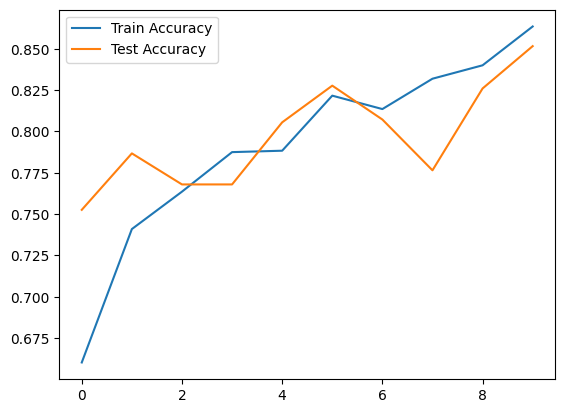

In [ ]:
import matplotlib.pyplot as plt

# رسم دقة التدريب (التعلم من الصور المعروفة)
plt.plot(history.history["accuracy"], label="Train Accuracy")

# رسم دقة الاختبار (القدرة على تمييز الصور الجديدة)
plt.plot(history.history["val_accuracy"], label="Test Accuracy")

# إظهار دليل الرسم (أسماء الخطوط)
plt.legend()

# عرض المخطط البياني النهائي
plt.show()

# # هلقيت بدي اشتغل على بيانات الاختبار الي الموديل مو شايفها

In [ ]:
#Evaluation
from sklearn.metrics import confusion_matrix, classification_report

# 1. جعل النموذج يتوقع نتائج صور الاختبار التي لم يرها من قبل
preds = model.predict(test_it)

# 2. تحويل التوقعات إلى أرقام صحيحة (0 أو 1)
# إذا كان الاحتمال أكبر من 0.5 يعتبره "1" (كلب)، وإلا فهو "0" (قطة)
pred_labels = (preds > 0.5).astype(int)

# 3. الحصول على الإجابات الصحيحة الفعلية من بيانات الاختبار
true_labels = test_it.classes

# 4. طباعة مصفوفة الارتباك (Confusion Matrix)
print(confusion_matrix(true_labels, pred_labels))

# 5. طباعة تقرير التصنيف المفصل
print(classification_report(true_labels, pred_labels))

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
[[329  38]
 [ 49 170]]
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       367
           1       0.82      0.78      0.80       219

    accuracy                           0.85       586
   macro avg       0.84      0.84      0.84       586
weighted avg       0.85      0.85      0.85       586



## شكل بنية النموذج (Figure 1: CNN Architecture)

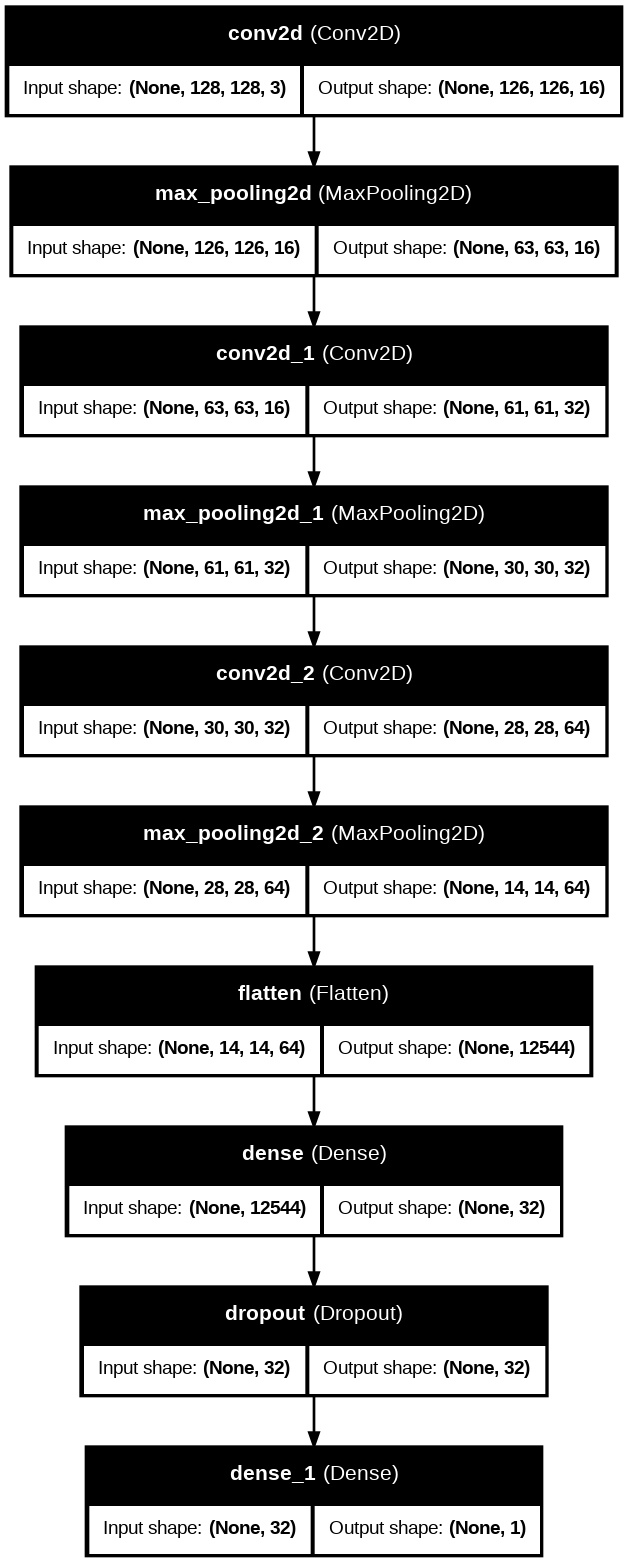

In [ ]:
from tensorflow.keras.utils import plot_model

# توليد صورة لمخطط الطبقات
plot_model(model, to_file='cnn_architecture.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=True,
           dpi=96)

# لعرضها في نوت بوك
from IPython.display import Image
Image(filename='cnn_architecture.png')

##  2. منحنيات الدقة والخسارة (Figure 2: Accuracy & Loss Curves)

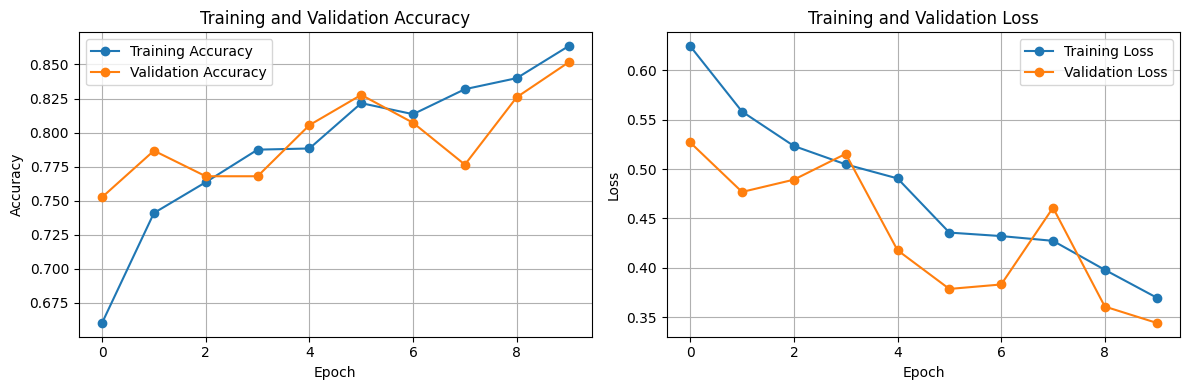

In [ ]:
plt.figure(figsize=(12, 4))

# رسم الدقة (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# رسم الخسارة (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_curves.png') # حفظ الصورة للبحث
plt.show()

## (Figure 3: Confusion Matrix)

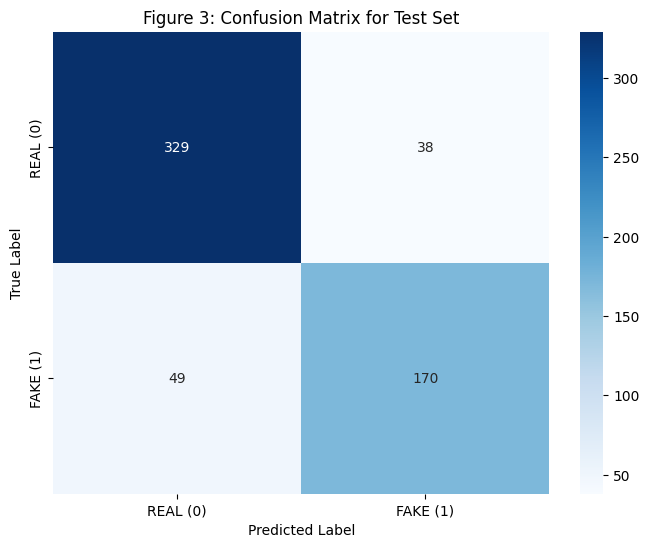

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# حساب المصفوفة
cm = confusion_matrix(true_labels, pred_labels)
labels = ['REAL (0)', 'FAKE (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Figure 3: Confusion Matrix for Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png') # حفظ الصورة للبحث
plt.show()

## 4. عينات التوقعات (Figure 4: Sample Predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


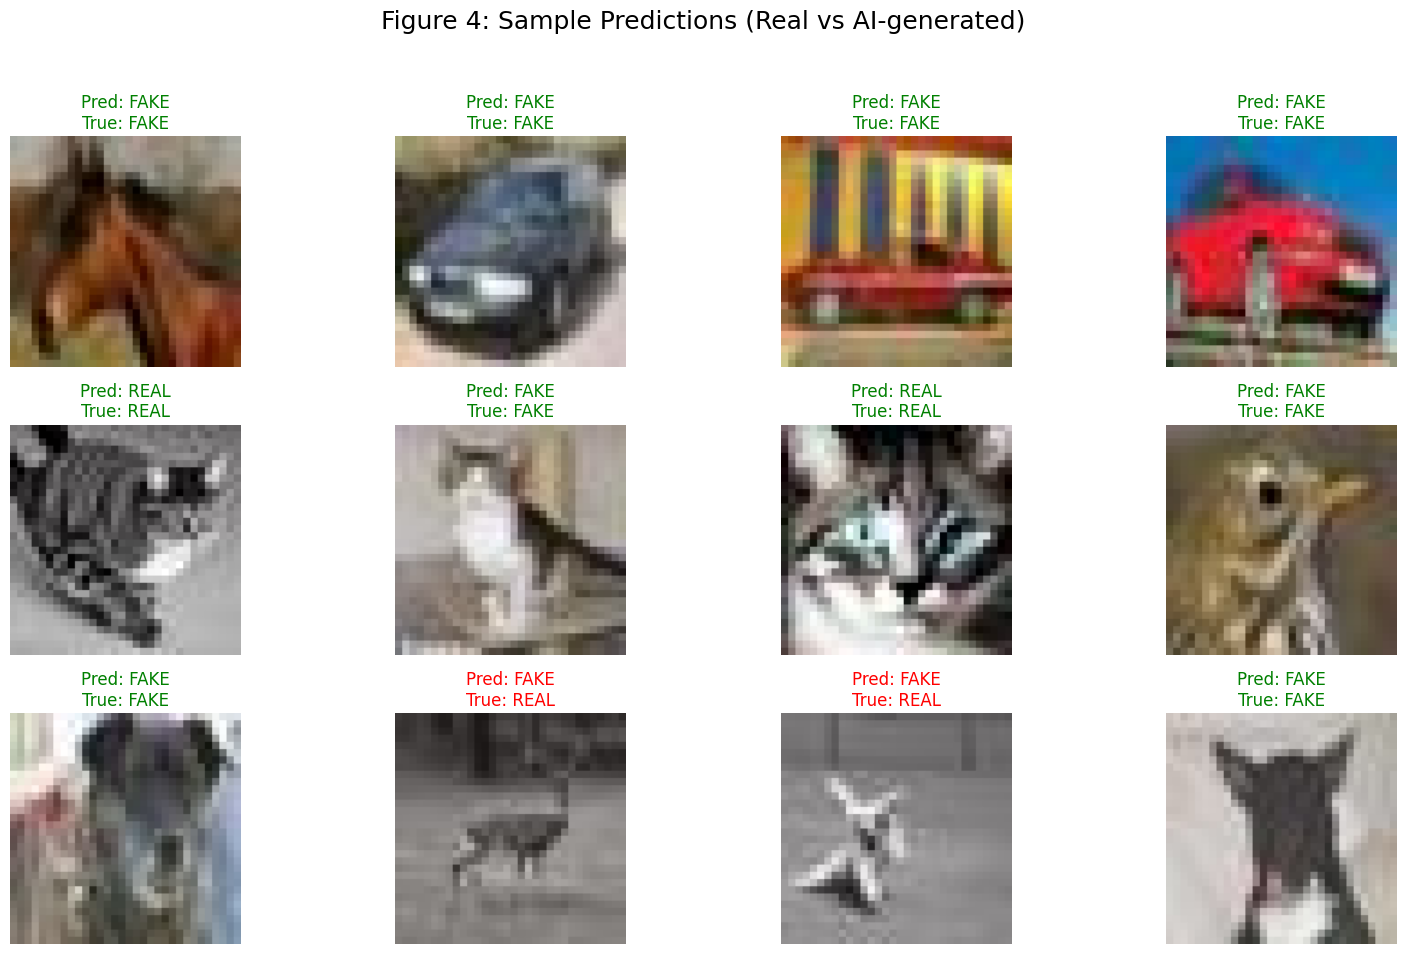

In [ ]:
# اختيار صور عشوائية من بيانات الاختبار
images, labels = next(test_it)
preds = model.predict(images)

plt.figure(figsize=(16, 10))
plt.suptitle("Figure 4: Sample Predictions (Real vs AI-generated)", fontsize=18)

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i])

    # تحويل القيم لأسماء فئات
    p_label = "REAL" if preds[i] > 0.5 else "FAKE"
    t_label = "REAL" if labels[i] > 0.5 else "FAKE"

    color = "green" if p_label == t_label else "red"

    plt.title(f"Pred: {p_label}\nTrue: {t_label}", color=color, fontsize=12)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('sample_predictions.png') # حفظ الصورة للبحث
plt.show()